**Execution time ~5'**

In [1]:
import scanpy as scp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import scrublet as scr
from scipy.linalg import inv

import sys
sys.path.append('../../')
from scCustomFunctions import *

from parameters import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [4]:
a = scp.read("/lustre/projects/Stembryo_Seq/meissner_qc.h5ad")
a.X = a.layers["counts"].copy()

# PCA

We perform the PCA analysis for each stage independently.

The steps performed are:

1. Normalize to mean number of counts (over the hole dataset)
2. Log1p scaling
3. Selection of highly varying genes
4. PCA retaining only the most relevant number of PCs
5. Batch correct over the samples of each stage (see methods employed below)

We correct the batches using:

1) Harmony algorithm.

In [5]:
scp.pp.normalize_total(a,target_sum=a.obs.loc[:,"nCounts"].mean())
scp.pp.log1p(a)

... storing 'stage' as categorical
... storing 'stage' as categorical
... storing 'stage' as categorical
... storing 'stage' as categorical
... storing 'stage' as categorical
... storing 'stage' as categorical


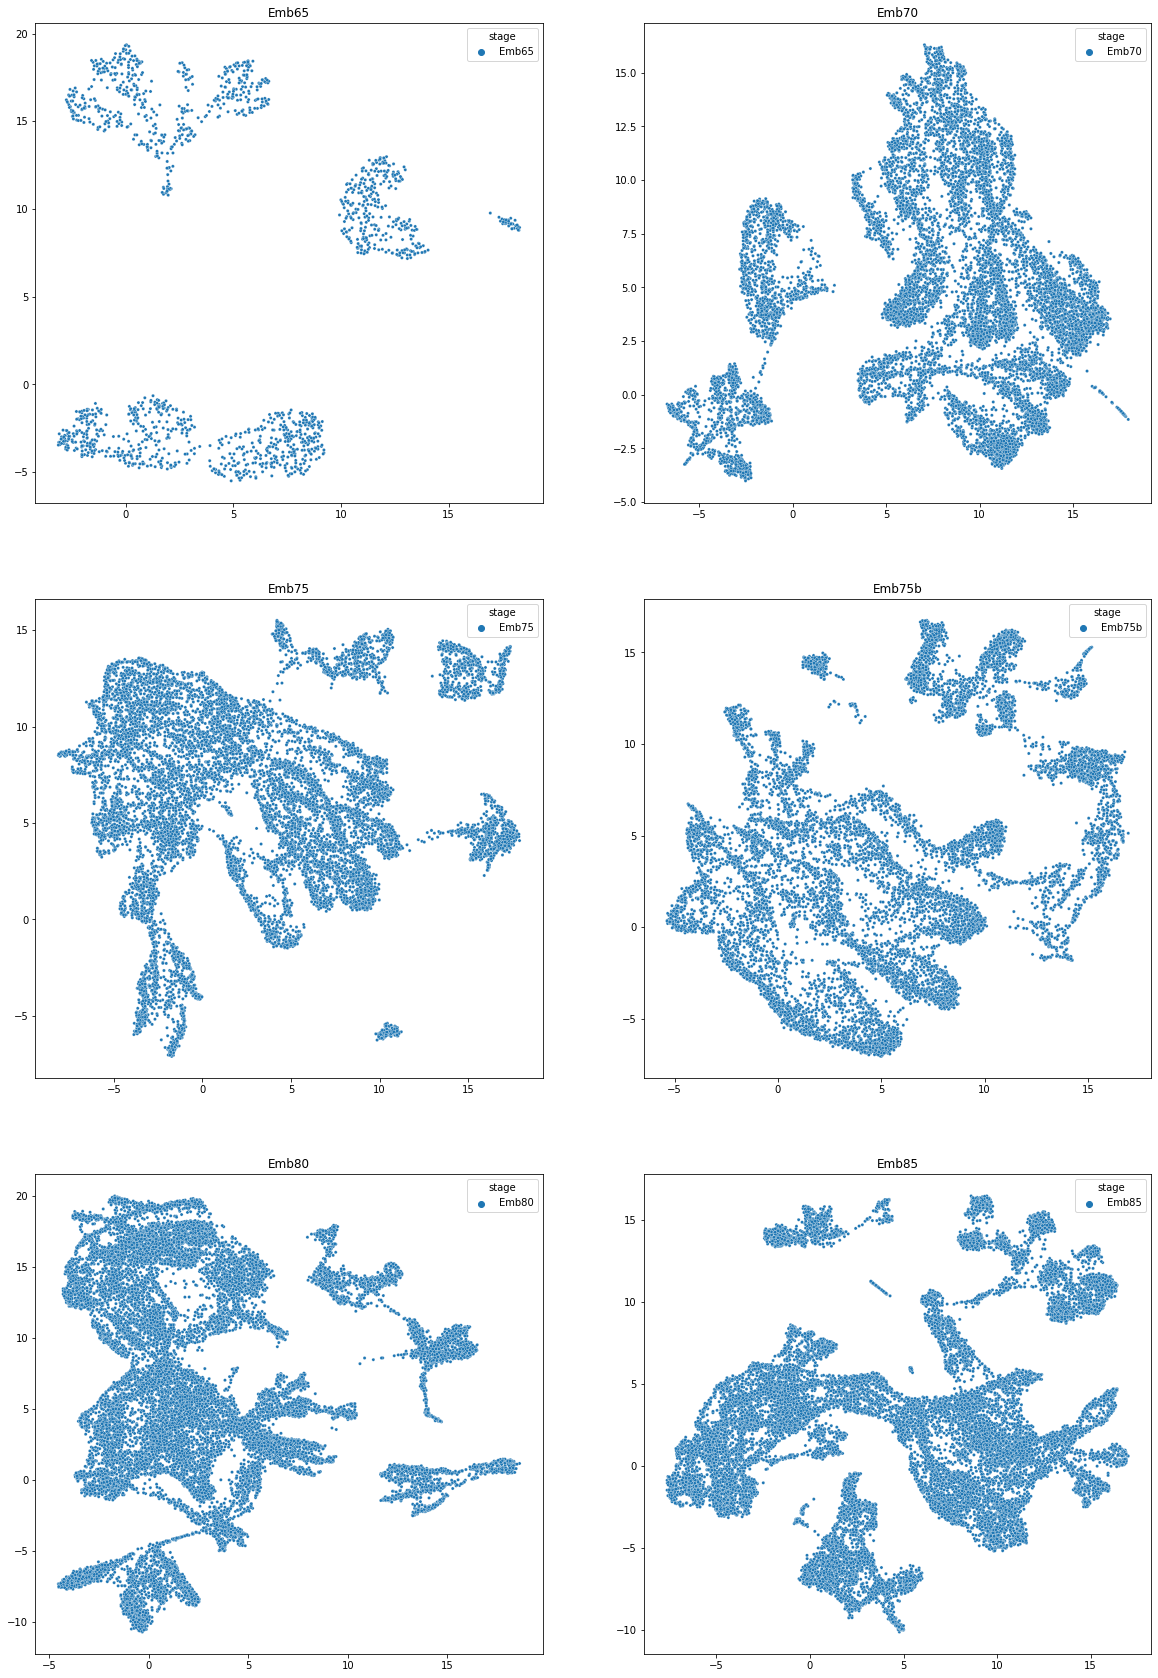

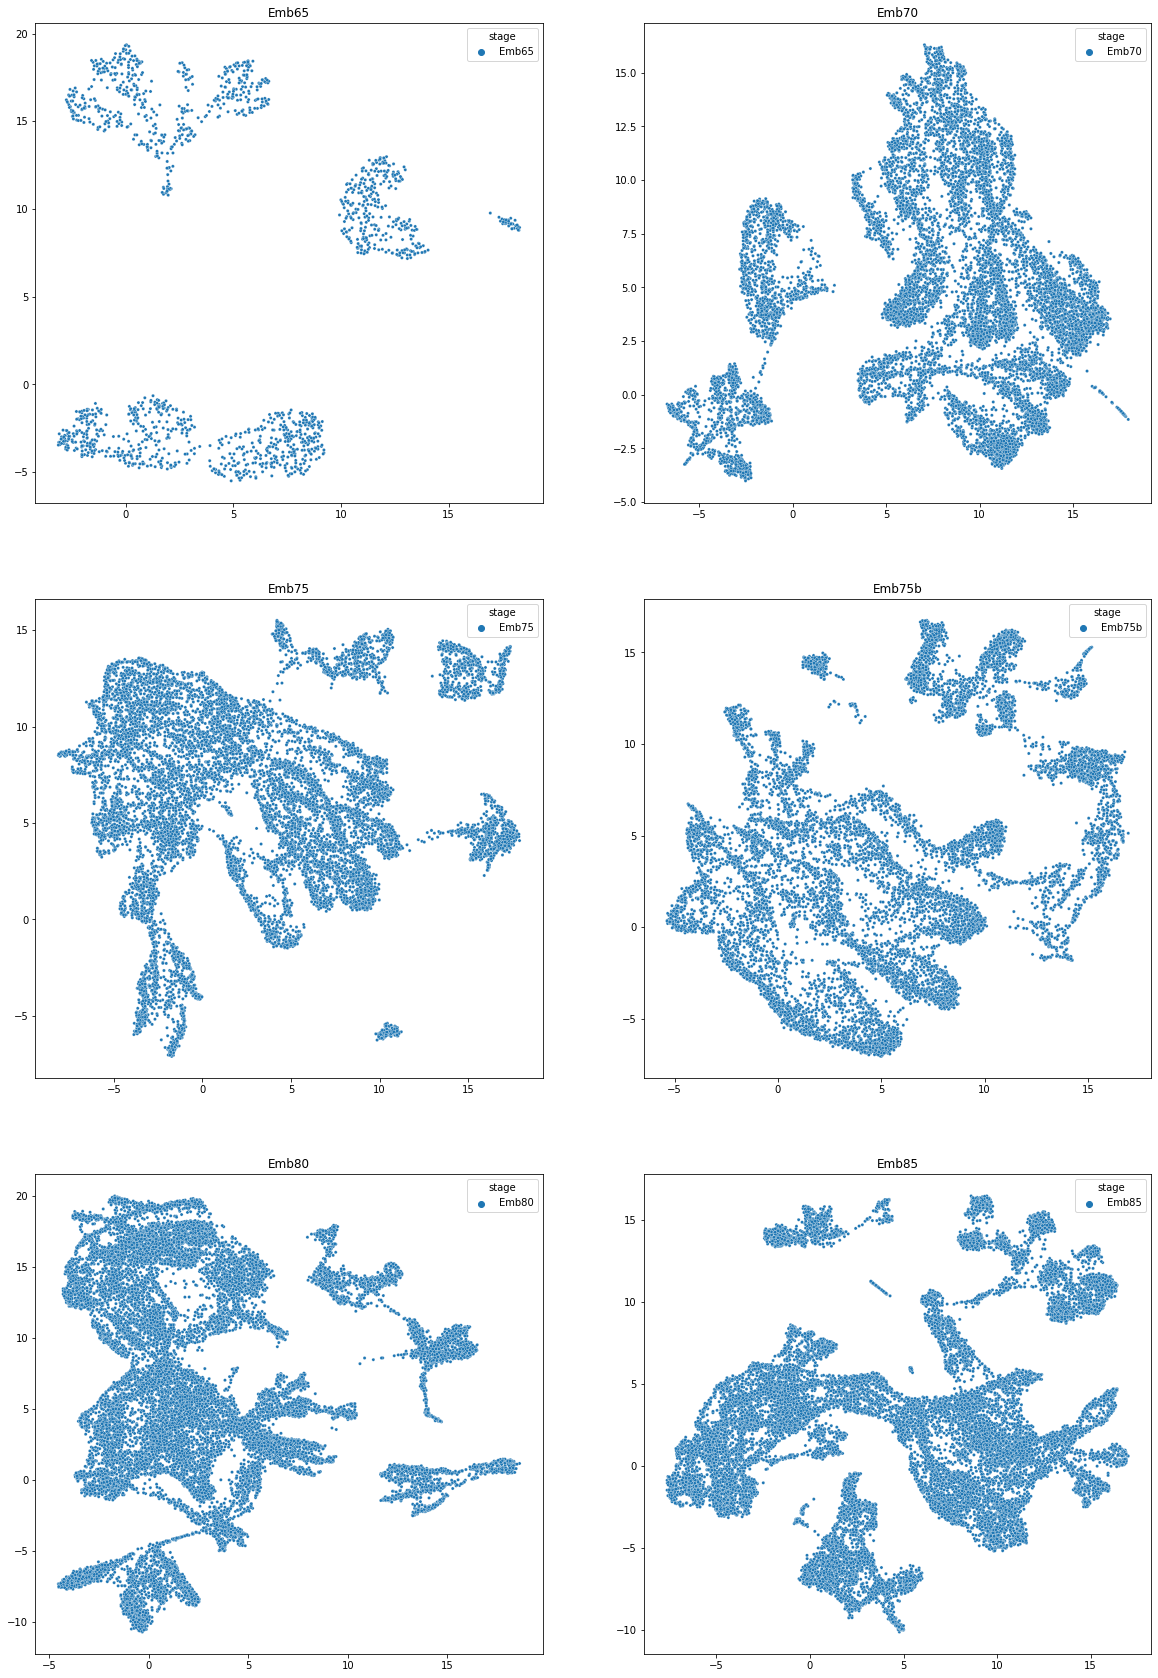

In [11]:
fig1,ax1 = plt.subplots(3,2,figsize=[20,30])
fig2,ax2 = plt.subplots(3,2,figsize=[20,30])
#fig3,ax3 = plt.subplots(5,2,figsize=[20,50])

a.obsm["X_pca_stages"] = np.zeros([a.shape[0],N_PCS])
a.obsm["X_umap_stages"] = np.zeros([a.shape[0],2])
a.obsm["X_pca_harmony_stages"] = np.zeros([a.shape[0],N_PCS])
a.obsm["X_umap_harmony_stages"] = np.zeros([a.shape[0],2])
for j,stage in enumerate(np.sort(a.obs["stage"].unique())):
    
    posx = j//2
    posy = j%2

    b = a[a.obs["stage"]==stage,:].copy()
    b.obs["stage"]=b.obs["stage"].astype(str)
    #b.obs["sample"]=b.obs["sample"].astype(str)
    scp.pp.highly_variable_genes(b,flavor=HVG_METHOD)
    remove_highly_variable_genes(b,SKIP_GENES) #Remove genes related with sex or cell cycle
    
    #Raw
    scp.pp.pca(b,n_comps=N_PCS,use_highly_variable=USE_HVGs)
    scp.pp.neighbors(b,knn=N_NEIGBOURS,n_pcs=N_PCS)

    umap_seed_with_paga(b,LOUVAIN_INITIALISATION) #Not used because the random state is not properly working
    scp.tl.umap(b,init_pos="paga")
    
    sb.scatterplot(b.obsm["X_umap"][:,0],b.obsm["X_umap"][:,1],hue=b.obs["stage"],s=10,ax=ax1[posx,posy])
    ax1[posx,posy].set_title(stage)
    
    a.obsm["X_pca_stages"][b.obs.index.values.astype(int),:] = b.obsm["X_pca"]
    a.obsm["X_umap_stages"][b.obs.index.values.astype(int),:] = b.obsm["X_umap"]
    
    #Harmony
    #scp.external.pp.harmony_integrate(b,"sample")
    scp.pp.neighbors(b,knn=N_NEIGBOURS,n_pcs=N_PCS,use_rep="X_pca")

    umap_seed_with_paga(b,LOUVAIN_INITIALISATION) #Not used because the random state is not properly working
    scp.tl.umap(b,init_pos="paga")
    
    sb.scatterplot(b.obsm["X_umap"][:,0],b.obsm["X_umap"][:,1],hue=b.obs["stage"],s=10,ax=ax2[posx,posy])
    ax2[posx,posy].set_title(stage)

    a.obsm["X_pca_stages"][b.obs.index.values.astype(int),:] = b.obsm["X_pca"]
    a.obsm["X_umap_stages"][b.obs.index.values.astype(int),:] = b.obsm["X_umap"]
    
    #MNN Some bug on the method and cannot be installed
    #fast_mnn_correct(b,"sample",k=N_NEIGBOURS)
    #scp.pp.neighbors(b,knn=N_NEIGBOURS,n_pcs=N_PCS,use_rep="X_pca_MNN")
    
    #umap_seed_with_paga(b,LOUVAIN_INITIALISATION)
    #scp.tl.umap(b,init_pos="paga")
    
    #sb.scatterplot(b.obsm["X_umap"][:,0],b.obsm["X_umap"][:,1],hue=b.obs["sample"],s=10,ax=ax3[posx,posy])
    #ax3[posx,posy].set_title(stage)

    #np.save("data/PCA_mnn"+stage+".png",b.obsm["X_pca_MNN"])
    #np.save("data/UMAP_mnn"+stage+".png",b.obsm["X_umap"])
    
fig1.savefig("Plots/2_DR_Stages_without_correction_umap.png",bbox_inches="tight",transparent=True)
fig2.savefig("Plots/2_DR_Stages_Harmony_umap.png",bbox_inches="tight",transparent=True)
#fig3.savefig("Plots/4_Batch_Correction/Stages_MNN_umap.png",bbox_inches="tight",transparent=True)

In [10]:
a.write("/lustre/projects/Stembryo_Seq/meissner_qc.h5ad");